In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name = "05b-cifar10-resnet"

In [ ]:
from torchvision.datasets.utils import download_url

#
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# help(download_url)
# download_url(dataset_url, "./")

# with tarfile.open("./cifar10.tgz", "r:gz") as tar:  # "r:gz" represents it opens the file in reading mode and gz compression format.
#     tar.extractall(path="./data")
    # help(tar.extractall)

data_dir = "./data/cifar10"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")  # train data folder.
print(classes)

In [159]:
# normalization & augmentation
# first element is mean tensor, the second element is standard deviation.
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # how do you get this mean and standart deviation.

# tt.Compose, composes several transforms together.
# args: list of transforms to compose.
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),  # crop the given image at a random location.
                         tt.RandomHorizontalFlip(),  # horizontally flip the given image randomly with a given probability.
                         # tt.RandomRotate,
                         # tt.RandomResizedCrop(256, scale=(0.5, 0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])  # normalize a tensor image with mean and standard deviation.
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [161]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)  # with indexing, the return value is a tuple object, with the first element as tensor and the second element as the class.
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 400  # batch size determines how many samples are processed before updating the model's weights.

In [ ]:
# data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [182]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)  # TODO find out how reshape method works.
    print(">> means is ", means)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means  # denormalize manipulation is the reverse manipulation of normalization, in normalization, the output = (input - mean) / std, while in denormalization, the output = input * std + mean, w.s.t. output from the normalization is the input of the denormalization.

def show_batch(dl):  # dl is a dataloader object/instance. with its element as a tuple
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))  # TODO permute method and clamp method
        break

>> means is  tensor([[[[0.4914]],

         [[0.4822]],

         [[0.4465]]]])


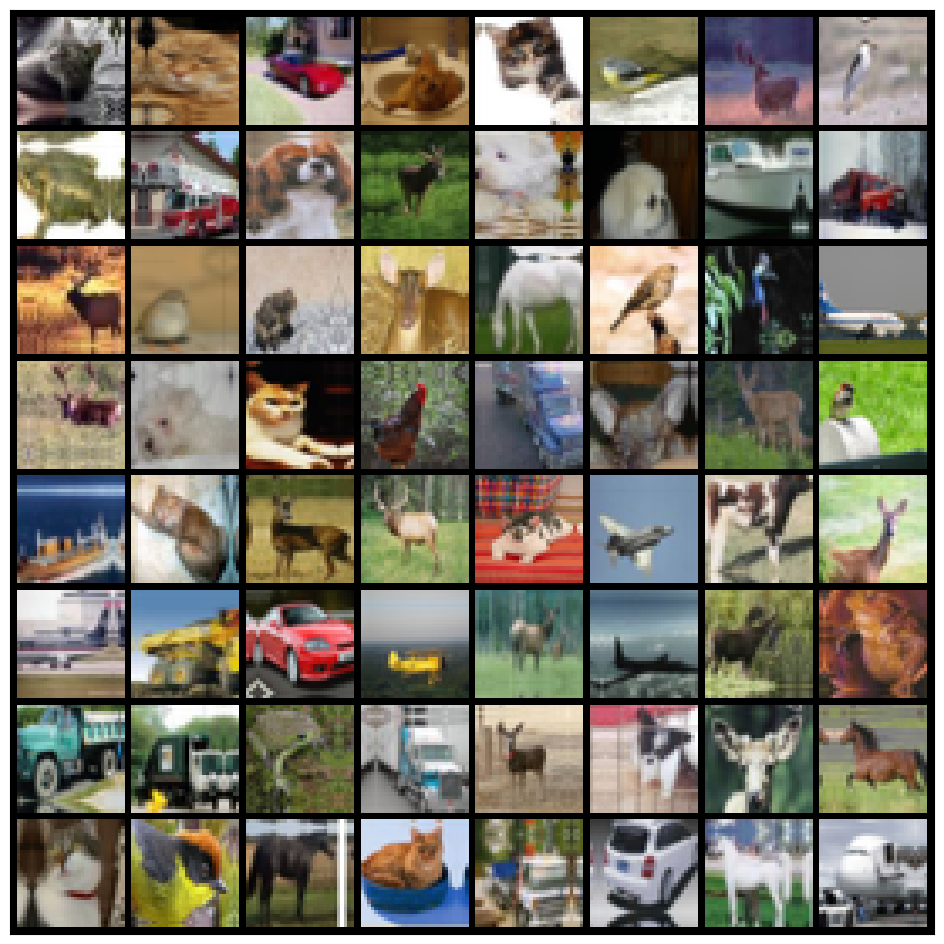

In [183]:
show_batch(train_dl)

In [184]:
# TODO find out the shape transferring/conversion.
a = torch.tensor(1)
print(a)
print(a.shape)
c = torch.tensor([1])
print(c.shape)
b = torch.tensor([1, 2])
b.shape
d = torch.tensor([
                    [1],
                    [2]
                ])
print(d.shape)

tensor(1)
torch.Size([])
torch.Size([1])
torch.Size([2, 1])


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # be careful, the variable 'data' should have the attribute `to`.

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):  # if this method is being called, it means the for loop will substitute its caller, which means each time it will yield a value.
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)
        

In [185]:
device = get_default_device()
device

device(type='cpu')

In [186]:
# ImageFolder, will transfer the folder/directory to an organized structure, so it's easier to manager the data/images
# DataLoader, transfer the data to tensors
# DeviceDataLoader, is a customized class, aiming for transferring the data to device/memory.
train_dl = DeviceDataLoader(train_dl, device)  # transfer the data to device. Till this step, the data hasn't been loaded to the device, because the __iter__ hasn't been called.
valid_dl = DeviceDataLoader(valid_dl, device)

In [187]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):  # here x is the input image tensor.
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x  # the return of the model will be the output of the chain model + the input tensor.
        # is this the batch normalization layer? TODO  << this is not normalization, the normalization has been done in the DataLoader by using tt.Compose()

In [190]:
# temp_model = SimpleResidualBlock()
simple_resnet = to_device(SimpleResidualBlock(), device)  # put the model to the device, here, the model is a SimpleResidualBlock instance.

for images, labels in train_dl:
    out = simple_resnet(images)  # here, this code calls the function __call__ defined in nn.Model, which is calling the forward method.
    print(out.shape)  # [batch_size, channel, rows, columns]
    break

del simple_resnet, images, labels  # here it deletes the objects.
torch.cuda.empty_cache()  # since I do not have gpu on my machine, I guess this line of code is redundant.


torch.Size([400, 3, 32, 32])


In [192]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # dim argument decides which dimension the max method gets the result from.
                                          # torch.max method returns a namedtuple ``(values, indices)`` where ``values`` is the maximum value of each row f the :attr:`input` tensor in the given dimension.
                                          # in this case, attribute `input` is outputs
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):  # here, outputs is the result of each bach training result
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))



In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(),
                                        nn.Dropout(0.2), nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out 
        
                    

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [145]:
epochs = 9
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [144]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, 
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [6], last_lr: 0.00040, train_loss: 0.4642, val_loss: 0.6334, val_acc: 0.7881
Epoch [7], last_lr: 0.00040, train_loss: 0.4269, val_loss: 0.4956, val_acc: 0.8373
Epoch [8], last_lr: 0.00040, train_loss: 0.4003, val_loss: 0.4549, val_acc: 0.8453
CPU times: total: 9h 3min 45s
Wall time: 47min 19s


In [146]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

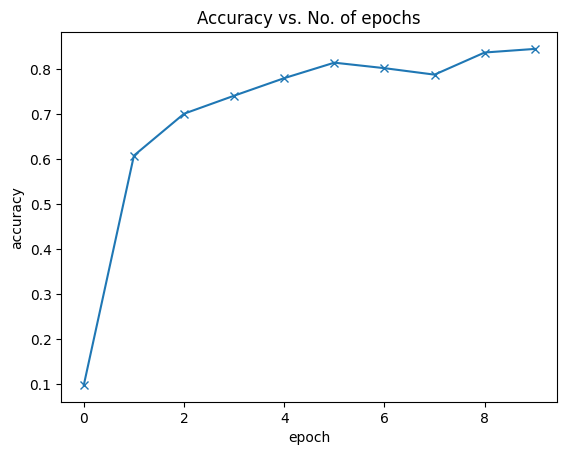

In [158]:
plot_accuracies(history)

In [150]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(val_losses, '-rx')
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', "Validation"])
    plt.title('Loss vs. No. of epochs')

In [151]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch No.")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs. Batch No.")

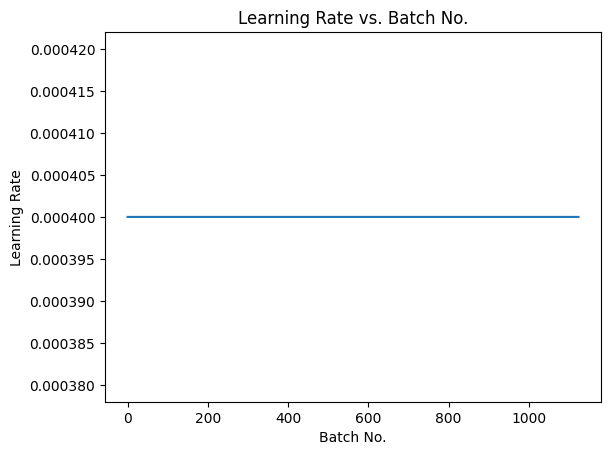

In [152]:
plot_lrs(history)

In [153]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7692488..2.3440151].


Label: airplane , Predicted: ship


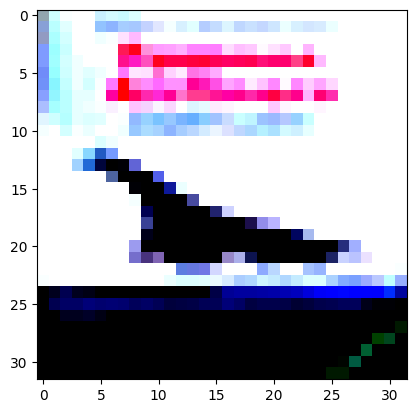

In [154]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ", Predicted:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.7537313].


Label: automobile , Predicted: truck


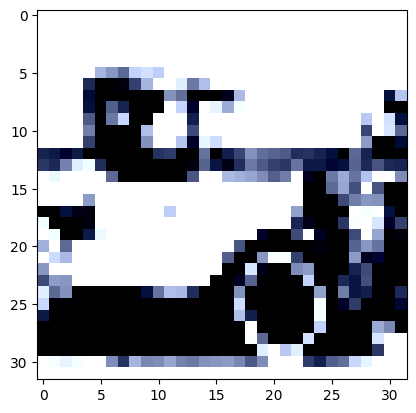

In [155]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ", Predicted:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5775534..2.1457746].


Label: frog , Predicted: frog


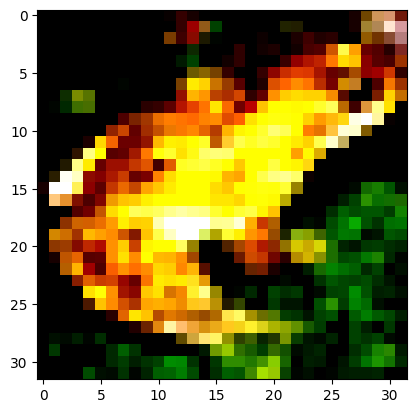

In [156]:
img, label = valid_ds[6753]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ", Predicted:", predict_image(img, model))

In [157]:
torch.save(model.state_dict(), "cifar10-resnet9.pth")